In [12]:
import numpy as np
import pandas as pd
import datetime as datetime
import ta
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import requests
from tqdm import tqdm
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from scipy.stats import t
import ta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


def get_historical_klines(symbol, interval, start_str, end_str=None):
    # Define the Binance API URL
    url = 'https://api.binance.com/api/v3/klines'

    # Set the parameters for the API request
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_str,
        'endTime': end_str,
        'limit': 1000  # We can fetch up to 1000 entries per call
    }

    # Make the GET request
    response = requests.get(url, params=params)

    # Raise an exception if the call was unsuccessful
    response.raise_for_status()

    # Parse the JSON response
    data = response.json()

    # Convert the data to a pandas DataFrame and set column names
    df = pd.DataFrame(data)
    df.columns = [
        'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
        'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
        'Taker Buy Quote Asset Volume', 'Ignore'
    ]

    # Convert timestamps to datetime objects
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

    # Set 'Open Time' as the index
    df.set_index('Open Time', inplace=True)

    # Calculate 200 SMA and Normalized Close
    df.loc[:, '200SMA'] = ta.trend.sma_indicator(df['Close'], window=200)
    df.dropna(inplace=True)
    df.loc[:, 'Close'] = df.loc[:, 'Close'].astype(float)
    df.loc[:, 'NormalizedClose'] = df['Close']/df['200SMA']

    return df['Close']

symbol1 = "LTCUSDT"
symbol2 = "ETHUSDT"
interval = "1d"  # 1 day interval
start_str = int(datetime.datetime(2022, 1, 1).timestamp() * 1000)  # Start from Jan 1, 2022
end_str = int(datetime.datetime(2024, 5, 3).timestamp() * 1000)  # End at May 3, 2024

historical_klines_df1 = get_historical_klines(symbol1, interval, start_str, end_str)
historical_klines_df2 = get_historical_klines(symbol2, interval, start_str, end_str)

print(historical_klines_df1.head())
print(historical_klines_df2.head())


Open Time
2022-07-19     57.9
2022-07-20     57.2
2022-07-21    58.02
2022-07-22    56.09
2022-07-23    56.32
Name: Close, dtype: object
Open Time
2022-07-19    1542.32
2022-07-20    1521.58
2022-07-21    1575.45
2022-07-22    1535.27
2022-07-23    1548.67
Name: Close, dtype: object


Epoch 1/10
12/12 - 9s - loss: 0.0015 - 9s/epoch - 754ms/step
Epoch 2/10
12/12 - 0s - loss: 0.0015 - 89ms/epoch - 7ms/step
Epoch 3/10
12/12 - 0s - loss: 0.0015 - 71ms/epoch - 6ms/step
Epoch 4/10
12/12 - 0s - loss: 0.0015 - 73ms/epoch - 6ms/step
Epoch 5/10
12/12 - 0s - loss: 0.0015 - 85ms/epoch - 7ms/step
Epoch 6/10
12/12 - 0s - loss: 0.0015 - 86ms/epoch - 7ms/step
Epoch 7/10
12/12 - 0s - loss: 0.0016 - 80ms/epoch - 7ms/step
Epoch 8/10
12/12 - 0s - loss: 0.0015 - 77ms/epoch - 6ms/step
Epoch 9/10
12/12 - 0s - loss: 0.0015 - 74ms/epoch - 6ms/step
Epoch 10/10
12/12 - 0s - loss: 0.0015 - 77ms/epoch - 6ms/step
3/3 [==============================] - 0s 4ms/step


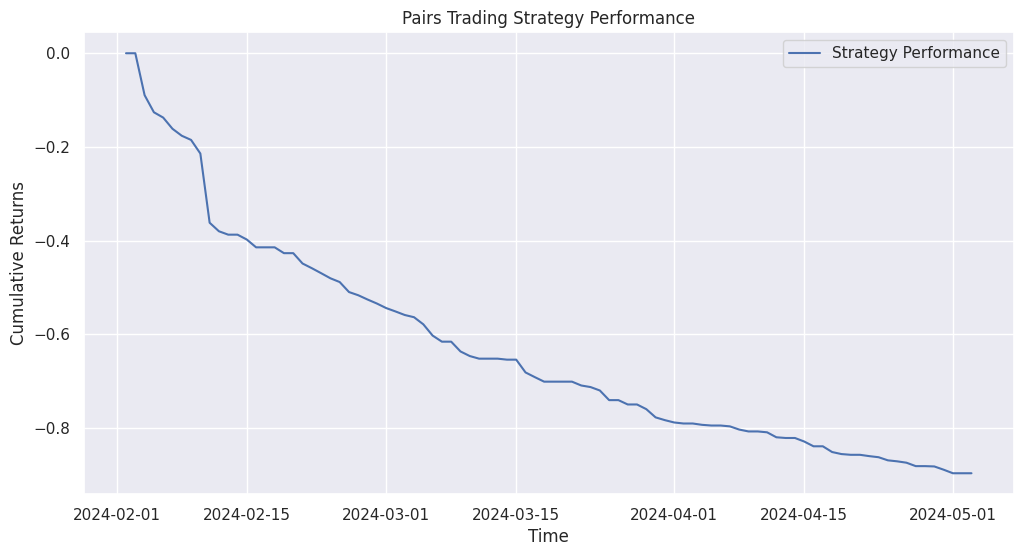

In [22]:
# Create DataFrames
df1 = pd.DataFrame({'Close': historical_klines_df1})
df2 = pd.DataFrame({'Close': historical_klines_df2})

# Normalize returns
def compute_normalized_returns(df):
    df['Returns'] = df['Close'].pct_change()
    df['200SMA'] = ta.trend.sma_indicator(df['Close'], window=200)
    df['NormalizedClose'] = df['Close'] / df['200SMA']
    df.dropna(inplace=True)
    return df

df1 = compute_normalized_returns(df1)
df2 = compute_normalized_returns(df2)

tickers = ['Asset1', 'Asset2']
returns_data = pd.DataFrame({
    tickers[0]: df1['Returns'],
    tickers[1]: df2['Returns']
}).dropna()

# Apply Gaussian Copula
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=returns_data)

def gaussian_copula_model(df):
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(df)
    return synthesizer

copula = gaussian_copula_model(returns_data)

# Generate conditional probabilities
def conditional_probabilities(copula, df):
    copula_samples = copula.sample(len(df))
    p1 = t.cdf(df[tickers[0]], 3)
    p2 = t.cdf(df[tickers[1]], 3)
    return p1, p2

p1, p2 = conditional_probabilities(copula, returns_data)

# Prepare LSTM input features
def create_lstm_features(df):
    df['LaggedReturns1'] = df[tickers[0]].shift(1)
    df['LaggedReturns2'] = df[tickers[1]].shift(1)
    df.dropna(inplace=True)
    features = ['LaggedReturns1', 'LaggedReturns2']
    return df[features], df[tickers[0]]

X, y = create_lstm_features(returns_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Utility function to reshape data for LSTM
def reshape_lstm_data(X):
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

# Reshape the data for LSTM model
X_train_lstm = reshape_lstm_data(X_train)
X_test_lstm = reshape_lstm_data(X_test)

# Define and train the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

lstm_model = build_lstm_model((X_train_lstm.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=2)

# Predict volatilities
train_preds = lstm_model.predict(X_train_lstm)
test_preds = lstm_model.predict(X_test_lstm)

# Function to calculate Z-score
def calculate_z_score(actual, simulated):
    return (actual - np.mean(simulated)) / np.std(simulated)

# Generate trading signals using Gaussian Copula and LSTM predictions
def generate_trading_signals(z_scores, volatilities, threshold=2.58):
    signals = []
    for z in z_scores:
        if abs(z) > threshold:
            signals.append(1 if z < 0 else -1)
        else:
            signals.append(0)
    return signals


# Trading strategy logic
def implement_trading_strategy(signals, returns, initial_capital=1):
    cumulative_returns = [initial_capital]
    for signal, ret in zip(signals, returns):
        cumulative_returns.append(cumulative_returns[-1] * (1 + signal * ret))
    return [cr - initial_capital for cr in cumulative_returns]

# Plot the trading strategy results
def plot_strategy_performance(strategy_returns):
    plt.figure(figsize=(12, 6))
    last_20_percent = int(len(df1) * 0.2)
    plt.plot(df1.index[-last_20_percent-1:],strategy_returns, label='Strategy Performance')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.title('Pairs Trading Strategy Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

# Apply the Trading Strategy
test_z_scores = calculate_z_score(y_test, test_preds)
test_volatilities = np.std(test_preds, axis=0)

# Generate trading signals
test_signals = generate_trading_signals(test_z_scores, test_volatilities)

# Implement the trading strategy
test_returns = implement_trading_strategy(test_signals, y_test)

# Plot strategy performance
plot_strategy_performance(test_returns)


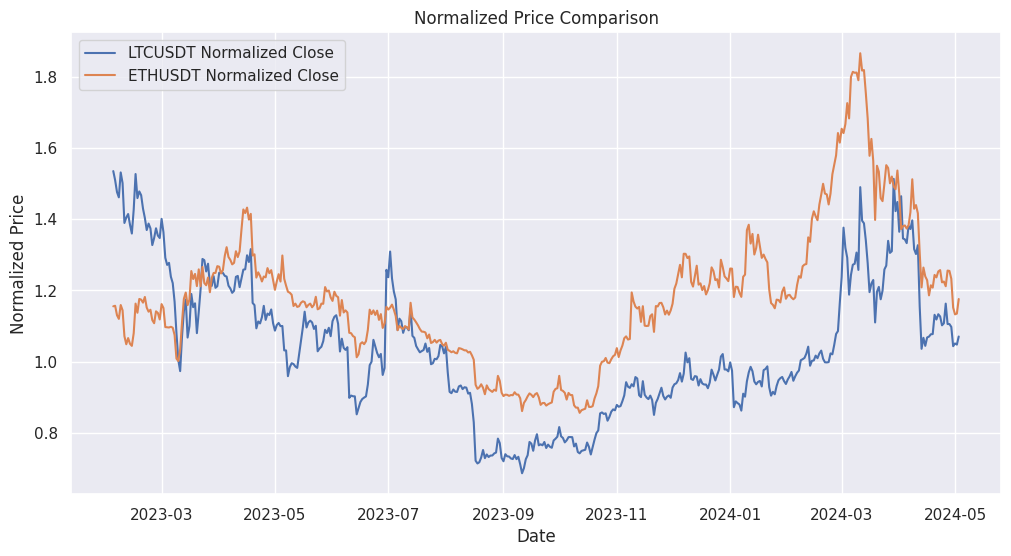

In [14]:
def plot_df1_df2(df1, df2, labels=['Asset1', 'Asset2']):
    plt.figure(figsize=(12, 6))
    plt.plot(df1.index, df1['NormalizedClose'], label=f'{labels[0]} Normalized Close')
    plt.plot(df2.index, df2['NormalizedClose'], label=f'{labels[1]} Normalized Close')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.title('Normalized Price Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
plot_df1_df2(df1, df2, labels=['LTCUSDT', 'ETHUSDT'])